In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
import seaborn as sns

NameError: name 'python' is not defined

# Data Preparation

### All Financial Data 4 Years

In [2]:
def calculate_beta_and_financials(ticker_list, start_date, end_date, output_csv,num,Year):
    global selected_bs,selected_cf
    results = []
    
    for ticker in ticker_list:
        
        stock = yf.download(ticker, start=start_date, end=end_date)
        market = yf.download('^GSPC', start=start_date, end=end_date)

        
        stock['Returns'] = stock['Adj Close'].pct_change().dropna()
        market['Returns'] = market['Adj Close'].pct_change().dropna()

        
        returns_data = pd.DataFrame({
            'Stock Returns': stock['Returns'],
            'Market Returns': market['Returns']
        }).dropna()
        try:
        
            returns_data['Year'] = returns_data.index.year

            beta_by_year = {}

            for year in returns_data['Year'].unique():
                yearly_data = returns_data[returns_data['Year'] == year]
                cov_matrix = np.cov(yearly_data['Stock Returns'], yearly_data['Market Returns'])
                cov_stock_market = cov_matrix[0, 1]
                market_var = cov_matrix[1, 1]
                beta = cov_stock_market / market_var
                beta_by_year[year] = beta
        
            
            stock_info = yf.Ticker(ticker)

            balance_sheet = stock_info.balancesheet
            selected_bs = balance_sheet.loc[['Current Assets', 'Cash And Cash Equivalents', 'Current Liabilities', 'Total Liabilities Net Minority Interest']]

            
            cash_flow = stock_info.cashflow
            selected_cf = cash_flow.loc[['Depreciation And Amortization', 'Capital Expenditure']]
            
            
            income_stmt = stock_info.incomestmt
            selected_is = income_stmt.loc[['Net Income', 'Interest Expense', 'Tax Rate For Calcs']]    

            result = {
                'Ticker': ticker,
                'Year' : year,
                'Beta': beta_by_year[Year],
                'Current Assets': selected_bs.loc['Current Assets'].values[num],
                'Cash And Cash Equivalents': selected_bs.loc['Cash And Cash Equivalents'].values[num],
                'Current Liabilities': selected_bs.loc['Current Liabilities'].values[num],
                'Total Liabilities Net Minority Interest': selected_bs.loc['Total Liabilities Net Minority Interest'].values[num],
                'Depreciation And Amortization': selected_cf.loc['Depreciation And Amortization'].values[num],
                'Capital Expenditure': selected_cf.loc['Capital Expenditure'].values[num],
                'Net Income': selected_is.loc['Net Income'].values[num],
                'Interest Expense': selected_is.loc['Interest Expense'].values[num],
                'Tax Rate For Calcs': selected_is.loc['Tax Rate For Calcs'].values[num]
            }


            results.append(result)
        except:
            pass

    
    results_df = pd.DataFrame(results)
    results_df["Year"] = Year
    results_df.to_csv(output_csv, index=False)
    print(f'Results saved to {output_csv}')



In [3]:
nasdaq_df = pd.read_csv("./data/nasdaq_screener.csv")
nasdaq_df = nasdaq_df[["Symbol","Country","Sector","Industry"]]
nasdaq_company_list = list(nasdaq_df["Symbol"])

In [26]:
dir_list = []
for (a,b) in [(0,2023),(1,2022),(2,2021),(3,2020)]:
    ticker_list = nasdaq_company_list 
    start_date = '2020-09-29'
    end_date = '2023-10-01'
    output_csv = 'financial_beta_results_{}.csv'.format(b)
    dir_list.append(output_csv)
    calculate_beta_and_financials(ticker_list, start_date, end_date, output_csv,a,b)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (

### market cap data

In [4]:
market_cap = pd.read_csv("./data/combined_marketcap.csv")
market_cap.shape

(20605, 3)

In [5]:
print(len(market_cap.Year.unique()),len(market_cap.Company.unique()))

4 5624


market cap has data of 5624 companies' 4 years data

### marco data

In [6]:
df_macro = pd.read_excel("./data/economic_indicators_last_4_years.xlsx",sheet_name = "Sheet1")
df_macro = df_macro.rename(columns={"Unnamed: 0":"date"})
df_macro.drop(["Reserve Ratio"],axis=1,inplace=True)
df_macro = df_macro.loc[df_macro["date"]!="2024-09-01",:]
df_macro["date"] = [str(x)[:4] for x in df_macro.date]

macro data has 5 years, however, Reserve Ratio is almost the same, can delete this column

In [6]:
df_macro

,date,CPI,PPI,Unemployment Rate,Federal Funds Rate,Inflation Rate,Overnight Lending Rate,10 Year Treasury Rate
0,2019,257.155,198.600,3.6,1.83,1.812210,1.88,1.65
1,2020,260.249,196.500,6.8,0.09,1.233584,0.09,0.68
2,2021,276.434,240.465,4.5,0.08,4.697859,0.08,1.48
3,2022,297.863,265.061,3.6,3.08,8.002800,3.08,3.83
4,2023,307.531,255.192,3.8,5.33,4.116338,5.33,4.59


### profile data

In [7]:
column_list = ["country","industry","sector","fullTimeEmployees",'exchange','quoteType']

In [8]:
def get_profile_number(column_list,company_list):   
    profile_info_dict = {}
    for company in company_list:
        try:
            ticker = yf.Ticker(company)
            ticker_info = ticker.info
            ticker_info_selected = {}
            for key in column_list:
                try:
                    value = ticker_info[key]
                    ticker_info_selected[key] = value
                except:
                    ticker_info_selected[key] = ""
            # ticker_info_selected["company"] = company
            profile_info_dict[company] = ticker_info_selected
        except:
            pass
        # profile_info_df = profile_info_df.append(profile_info_dict)
    profile_info_df = pd.DataFrame(profile_info_dict)
    return profile_info_df

In [9]:
profile_df = pd.read_csv("./data/profile_information.csv")
profile_df = profile_df.drop_duplicates()
profile_df = profile_df.rename(columns={"Unnamed: 0":"Ticker"})

In [10]:
profile_df.head()

,Ticker,country,industry,sector,fullTimeEmployees,exchange,quoteType
0,A,United States,Diagnostics & Research,Healthcare,17400.0,NYQ,EQUITY
1,AA,United States,Aluminum,Basic Materials,13600.0,NYQ,EQUITY
2,AACG,China,Education & Training Services,Consumer Defensive,581.0,NGM,EQUITY
3,AACT,United States,Shell Companies,Financial Services,NaN,NYQ,EQUITY
4,AADI,United States,Biotechnology,Healthcare,70.0,NCM,EQUITY


In [11]:
profile_df.shape

(5016, 7)

### Merge Data togetger

In [11]:
import os

#### financial data merger

In [12]:
document_list = ["Txx","mcy","cly","wyw","yjl","hwj"]

In [13]:
financial_df = pd.DataFrame()
# 使用列表来存储每个 DataFrame
dfs = []

for document_name in document_list:
    document_name_full = "./data/{}".format(document_name)
    print("Is Reading {}".format(document_name_full))
    file_list = os.listdir(document_name_full)
    try:
        file_list.remove(".DS_Store")
    except:
        pass

    for file_name in file_list:
        file_name_full = document_name_full + "/" + file_name
        print(file_name_full)
        df_unit = pd.read_csv(file_name_full)
        dfs.append(df_unit)  # 将每个 DataFrame 添加到列表中
        
        # financial_df = financial_df.append(df_unit) 报错 AttributeError: 'DataFrame' object has no attribute 'append'
# 使用 pd.concat 连接所有 DataFrame
financial_df = pd.concat(dfs, ignore_index=True)

#check
print(financial_df.shape)

Is Reading ./data/Txx
./data/Txx/financial_beta_results_2020.csv
./data/Txx/financial_beta_results_2021.csv
./data/Txx/financial_beta_results_2023.csv
./data/Txx/financial_beta_results_2022.csv
Is Reading ./data/mcy
./data/mcy/financial_beta_results_2020.csv
./data/mcy/financial_beta_results_2021.csv
./data/mcy/financial_beta_results_2023.csv
./data/mcy/financial_beta_results_2022.csv
Is Reading ./data/cly
./data/cly/financial_beta_results_2020.csv
./data/cly/financial_beta_results_2021.csv
./data/cly/financial_beta_results_2023.csv
./data/cly/financial_beta_results_2022.csv
Is Reading ./data/wyw
./data/wyw/financial_beta_results_2021.xls
./data/wyw/financial_beta_results_2020.xls
./data/wyw/financial_beta_results_2022.xls
./data/wyw/financial_beta_results_2023.xls
Is Reading ./data/yjl
./data/yjl/financial_beta_results_2020.csv
./data/yjl/financial_beta_results_2021.csv
./data/yjl/financial_beta_results_2023.csv
./data/yjl/financial_beta_results_2022.csv
Is Reading ./data/hwj
./data/h

In [15]:
financial_df

,Ticker,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,Net Income,Interest Expense,Tax Rate For Calcs
0,A,2020,0.852718,3.415000e+09,1.441000e+09,1.467000e+09,4.754000e+09,3.080000e+08,-1.190000e+08,7.190000e+08,7.800000e+07,0.146000
1,AA,2020,1.552169,4.520000e+09,1.607000e+09,2.761000e+09,9.844000e+09,6.530000e+08,-3.530000e+08,-1.700000e+08,1.460000e+08,0.270000
2,AADI,2020,1.253655,1.868500e+07,4.455000e+06,3.005800e+07,3.125700e+07,9.000000e+03,NaN,-3.478000e+06,8.150000e+05,0.270000
3,AAL,2020,1.527247,1.109500e+10,2.450000e+08,1.656900e+10,6.887500e+10,2.370000e+09,-2.131000e+09,-8.885000e+09,1.227000e+09,0.224221
4,AAOI,2020,1.086727,2.091690e+08,4.342500e+07,1.031480e+08,2.029140e+08,2.473300e+07,-1.628400e+07,-5.845200e+07,5.635000e+06,0.270000
...,...,...,...,...,...,...,...,...,...,...,...,...
13919,ZTEK,2022,1.066477,1.795301e+07,1.035732e+07,2.419818e+06,2.904674e+06,5.396930e+05,-2.272934e+06,-1.441427e+07,1.206240e+05,0.000000
13920,ZTO,2022,0.798498,2.447503e+10,1.169277e+10,1.640532e+10,2.405112e+10,2.670546e+09,-7.412732e+09,6.809056e+09,1.905210e+08,0.197100
13921,ZTS,2022,0.964930,7.506000e+09,3.577000e+09,3.167000e+09,1.052200e+10,4.650000e+08,-5.860000e+08,2.114000e+09,2.210000e+08,0.205000
13922,ZUO,2022,1.677468,5.185520e+08,2.032390e+08,3.116190e+08,5.714380e+08,1.873800e+07,-1.063400e+07,-1.979700e+08,1.513300e+07,0.056000


In [16]:
financial_df.shape

(13924, 12)

#### merge financial data with profile data

In [14]:
financial_profile = financial_df.merge(profile_df)

In [15]:
financial_profile.head()

,Ticker,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,Net Income,Interest Expense,Tax Rate For Calcs,country,industry,sector,fullTimeEmployees,exchange,quoteType
0,A,2020,0.852718,3.415000e+09,1.441000e+09,1.467000e+09,4.754000e+09,3.080000e+08,-1.190000e+08,7.190000e+08,7.800000e+07,0.146000,United States,Diagnostics & Research,Healthcare,17400.0,NYQ,EQUITY
1,AA,2020,1.552169,4.520000e+09,1.607000e+09,2.761000e+09,9.844000e+09,6.530000e+08,-3.530000e+08,-1.700000e+08,1.460000e+08,0.270000,United States,Aluminum,Basic Materials,13600.0,NYQ,EQUITY
2,AADI,2020,1.253655,1.868500e+07,4.455000e+06,3.005800e+07,3.125700e+07,9.000000e+03,NaN,-3.478000e+06,8.150000e+05,0.270000,United States,Biotechnology,Healthcare,70.0,NCM,EQUITY
3,AAL,2020,1.527247,1.109500e+10,2.450000e+08,1.656900e+10,6.887500e+10,2.370000e+09,-2.131000e+09,-8.885000e+09,1.227000e+09,0.224221,United States,Airlines,Industrials,137400.0,NMS,EQUITY
4,AAOI,2020,1.086727,2.091690e+08,4.342500e+07,1.031480e+08,2.029140e+08,2.473300e+07,-1.628400e+07,-5.845200e+07,5.635000e+06,0.270000,United States,Communication Equipment,Technology,2149.0,NGM,EQUITY


In [19]:
financial_profile.shape

(13026, 18)

In [20]:
financial_profile.head()

,Ticker,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,Net Income,Interest Expense,Tax Rate For Calcs,country,industry,sector,fullTimeEmployees,exchange,quoteType
0,A,2020,0.852718,3.415000e+09,1.441000e+09,1.467000e+09,4.754000e+09,3.080000e+08,-1.190000e+08,7.190000e+08,7.800000e+07,0.146000,United States,Diagnostics & Research,Healthcare,17400.0,NYQ,EQUITY
1,AA,2020,1.552169,4.520000e+09,1.607000e+09,2.761000e+09,9.844000e+09,6.530000e+08,-3.530000e+08,-1.700000e+08,1.460000e+08,0.270000,United States,Aluminum,Basic Materials,13600.0,NYQ,EQUITY
2,AADI,2020,1.253655,1.868500e+07,4.455000e+06,3.005800e+07,3.125700e+07,9.000000e+03,NaN,-3.478000e+06,8.150000e+05,0.270000,United States,Biotechnology,Healthcare,70.0,NCM,EQUITY
3,AAL,2020,1.527247,1.109500e+10,2.450000e+08,1.656900e+10,6.887500e+10,2.370000e+09,-2.131000e+09,-8.885000e+09,1.227000e+09,0.224221,United States,Airlines,Industrials,137400.0,NMS,EQUITY
4,AAOI,2020,1.086727,2.091690e+08,4.342500e+07,1.031480e+08,2.029140e+08,2.473300e+07,-1.628400e+07,-5.845200e+07,5.635000e+06,0.270000,United States,Communication Equipment,Technology,2149.0,NGM,EQUITY


In [21]:
financial_profile.shape

(13026, 18)

#### merge macro data

In [16]:
df_macro = df_macro.rename(columns={"date":"Year"})
df_macro["Year"] = df_macro["Year"].astype(int)
financial_profile_macro = financial_profile.merge(df_macro)
financial_profile_macro.shape

(13026, 25)

In [23]:
financial_profile_macro.head()

,Ticker,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,Net Income,...,fullTimeEmployees,exchange,quoteType,CPI,PPI,Unemployment Rate,Federal Funds Rate,Inflation Rate,Overnight Lending Rate,10 Year Treasury Rate
0,A,2020,0.852718,3.415000e+09,1.441000e+09,1.467000e+09,4.754000e+09,3.080000e+08,-1.190000e+08,7.190000e+08,...,17400.0,NYQ,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68
1,AA,2020,1.552169,4.520000e+09,1.607000e+09,2.761000e+09,9.844000e+09,6.530000e+08,-3.530000e+08,-1.700000e+08,...,13600.0,NYQ,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68
2,AADI,2020,1.253655,1.868500e+07,4.455000e+06,3.005800e+07,3.125700e+07,9.000000e+03,NaN,-3.478000e+06,...,70.0,NCM,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68
3,AAL,2020,1.527247,1.109500e+10,2.450000e+08,1.656900e+10,6.887500e+10,2.370000e+09,-2.131000e+09,-8.885000e+09,...,137400.0,NMS,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68
4,AAOI,2020,1.086727,2.091690e+08,4.342500e+07,1.031480e+08,2.029140e+08,2.473300e+07,-1.628400e+07,-5.845200e+07,...,2149.0,NGM,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68


In [ ]:
financial_profile_macro.head()

,Ticker,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,Net Income,...,fullTimeEmployees,exchange,quoteType,CPI,PPI,Unemployment Rate,Federal Funds Rate,Inflation Rate,Overnight Lending Rate,10 Year Treasury Rate
0,A,2020,0.852718,3.415000e+09,1.441000e+09,1.467000e+09,4.754000e+09,3.080000e+08,-1.190000e+08,7.190000e+08,...,17400.0,NYQ,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68
1,AA,2020,1.552169,4.520000e+09,1.607000e+09,2.761000e+09,9.844000e+09,6.530000e+08,-3.530000e+08,-1.700000e+08,...,13600.0,NYQ,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68
2,AADI,2020,1.253655,1.868500e+07,4.455000e+06,3.005800e+07,3.125700e+07,9.000000e+03,NaN,-3.478000e+06,...,70.0,NCM,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68
3,AAL,2020,1.527247,1.109500e+10,2.450000e+08,1.656900e+10,6.887500e+10,2.370000e+09,-2.131000e+09,-8.885000e+09,...,137400.0,NMS,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68
4,AAOI,2020,1.086727,2.091690e+08,4.342500e+07,1.031480e+08,2.029140e+08,2.473300e+07,-1.628400e+07,-5.845200e+07,...,2149.0,NGM,EQUITY,260.249,196.5,6.8,0.09,1.233584,0.09,0.68


#### merge market cap data

In [17]:
market_cap = market_cap.rename(columns = {"Company":"Ticker"})
financial_profile_macro_y = financial_profile_macro.merge(market_cap)
financial_profile_macro_y = financial_profile_macro_y.dropna()


In [25]:
financial_profile_macro_y.shape

(11172, 26)

In [26]:
financial_profile_macro_y['Ticker'].nunique()

3252

# 利用历史数据 - 将过往marketcap作为X
## before data preprocessing
目标数据结构：x2023 y2020 2021 2022
当前结构：X*4year y

1- set new columns:  Market_Cap_20 Market_Cap_21 Market_Cap_22 Market_Cap_23
2- Market_Cap_20 = 

In [18]:
# 使用 pivot 将 year 转为列
market_cap_new = market_cap.pivot(index='Ticker', columns='Year', values='Market_Cap')

# 重命名列，使得列名包含 Market_Cap_ 前缀
market_cap_new.columns = [f"Market_Cap_{col}" for col in market_cap_new.columns]

# 重置索引（可选）
market_cap_new = market_cap_new.reset_index()

market_cap_new

,Ticker,Market_Cap_2020,Market_Cap_2021,Market_Cap_2022,Market_Cap_2023
0,A,2.821052e+10,4.430328e+10,3.438663e+10,3.184841e+10
1,AA,2.913570e+09,1.226054e+10,8.491993e+09,7.406037e+09
2,AACG,3.546450e+07,7.476300e+07,5.463450e+07,3.578400e+07
3,AACT,NaN,NaN,NaN,5.135000e+08
4,AADI,5.538330e+08,7.229367e+08,3.478071e+08,1.191356e+08
...,...,...,...,...,...
5619,ZVRA,4.756649e+08,4.909241e+08,3.283351e+08,2.536178e+08
5620,ZVSA,NaN,NaN,3.755940e+09,4.887610e+07
5621,ZWS,5.100492e+09,1.098896e+10,4.187736e+09,4.789403e+09
5622,ZYME,3.309388e+09,2.063217e+09,4.369415e+08,4.504405e+08


In [28]:
market_cap_new.isna().sum()

Ticker                0
Market_Cap_2020    1157
Market_Cap_2021     549
Market_Cap_2022     185
Market_Cap_2023       0
dtype: int64

删除 financial_profile_macro 中原有的 2020-2022的数据，并merge，之后删除 Market_cap 列

In [19]:
financial_profile_macro_2023 = financial_profile_macro [ financial_profile_macro['Year'] == 2023 ]

In [20]:
financial_profile_macro_2023_y = financial_profile_macro_2023.merge(market_cap_new)
financial_profile_macro_2023_y = financial_profile_macro_2023_y.dropna()
financial_profile_macro_2023_y

,Ticker,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,Net Income,...,PPI,Unemployment Rate,Federal Funds Rate,Inflation Rate,Overnight Lending Rate,10 Year Treasury Rate,Market_Cap_2020,Market_Cap_2021,Market_Cap_2022,Market_Cap_2023
0,A,2023,0.912959,4.186000e+09,1.590000e+09,1.603000e+09,4.918000e+09,2.710000e+08,-2.980000e+08,1.240000e+09,...,255.192,3.8,5.33,4.116338,5.33,4.59,2.821052e+10,4.430328e+10,3.438663e+10,3.184841e+10
1,AA,2023,1.959706,4.405000e+09,9.440000e+08,3.030000e+09,8.310000e+09,6.320000e+08,-5.310000e+08,-6.510000e+08,...,255.192,3.8,5.33,4.116338,5.33,4.59,2.913570e+09,1.226054e+10,8.491993e+09,7.406037e+09
2,AADI,2023,0.681302,1.245860e+08,6.288800e+07,2.639500e+07,2.722800e+07,1.690000e+05,-3.972000e+06,-6.576500e+07,...,255.192,3.8,5.33,4.116338,5.33,4.59,5.538330e+08,7.229367e+08,3.478071e+08,1.191356e+08
3,AAL,2023,1.297721,1.357200e+10,5.780000e+08,2.206200e+10,6.826000e+10,2.254000e+09,-2.596000e+09,8.220000e+08,...,255.192,3.8,5.33,4.116338,5.33,4.59,8.070892e+09,1.347557e+10,7.906716e+09,8.412379e+09
4,AAOI,2023,1.733689,1.726050e+08,4.536600e+07,9.335800e+07,1.743170e+08,2.042700e+07,-9.667000e+06,-5.604800e+07,...,255.192,3.8,5.33,4.116338,5.33,4.59,4.600766e+08,2.936311e+08,1.112363e+08,4.486258e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3489,ZS,2023,1.802321,3.396617e+09,1.423080e+09,3.112887e+09,3.430866e+09,8.093200e+07,-1.948960e+08,-5.770600e+07,...,255.192,3.8,5.33,4.116338,5.33,4.59,2.145382e+10,3.998593e+10,2.506478e+10,2.372592e+10
3490,ZTEK,2023,0.501722,6.248953e+06,3.521420e+06,1.819004e+06,2.411845e+06,6.137140e+05,-3.200990e+05,-1.170399e+07,...,255.192,3.8,5.33,4.116338,5.33,4.59,6.138832e+07,4.474064e+08,1.727197e+08,1.300600e+08
3491,ZTO,2023,0.770027,2.695355e+10,1.233388e+10,2.006118e+10,2.818481e+10,2.875209e+09,-6.669781e+09,8.749004e+09,...,255.192,3.8,5.33,4.116338,5.33,4.59,1.774226e+10,1.833594e+10,1.437093e+10,1.445465e+10
3492,ZTS,2023,0.968791,6.343000e+09,2.039000e+09,1.889000e+09,9.295000e+09,4.910000e+08,-7.320000e+08,2.344000e+09,...,255.192,3.8,5.33,4.116338,5.33,4.59,7.266135e+10,8.577745e+10,6.593884e+10,7.804689e+10


### merge T-3期数据 保存到csv

In [21]:
financial_profile_macro_2023_y.to_csv("financial_profile_macro_2023_y.csv", index=False, encoding='utf-8')

In [22]:
financial_profile_macro_2023_y.shape

(2307, 29)

# Data Descriptive Analysis

<AxesSubplot:ylabel='Frequency'>

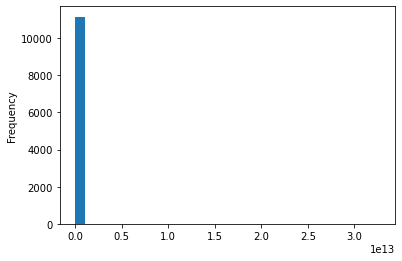

In [ ]:
financial_profile_macro_y["Market_Cap"].plot.hist(bins=30)

In [ ]:
stand_list = ['Beta', 'Current Assets', 'Cash And Cash Equivalents',
       'Current Liabilities', 'Total Liabilities Net Minority Interest',
       'Depreciation And Amortization', 'Capital Expenditure', 'Net Income',
       'Interest Expense', 'Tax Rate For Calcs', 'fullTimeEmployees']

In [ ]:
len(stand_list)

11

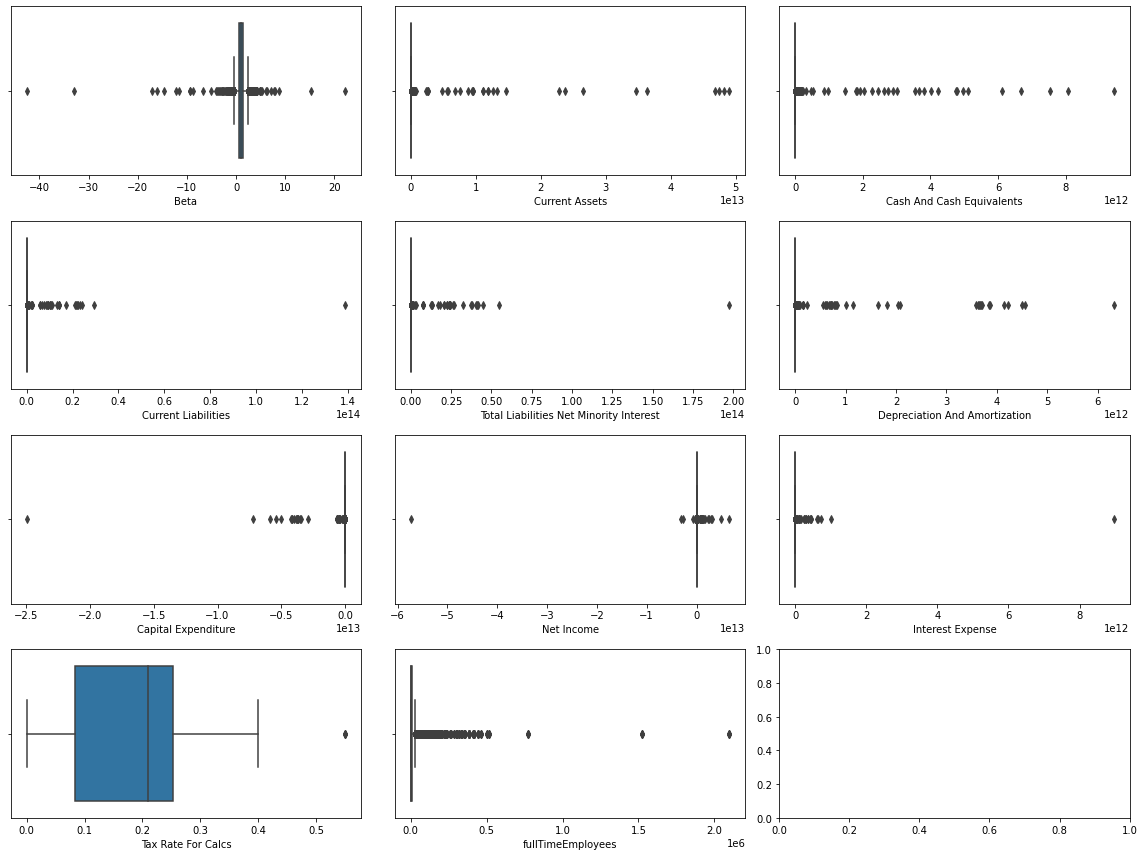

In [ ]:
fig, axs = plt.subplots(4,3,figsize=(16,12))
axs = axs.flatten()
for idx, feature in enumerate(stand_list):
    sns.boxplot(x=financial_profile_macro_y[feature], ax=axs[idx])
plt.tight_layout()

In [ ]:
# the outliers issue is severe
# the dataset is not a balanced data, which will lead to some problems
# in order to avoid this problem, we need to clean this outliers.
# because for some company, the market cap does not purely come from the financial and profile data
# sometimes, it come from traders' emotion, some news and so on. 
# for outliers, it's hard to predict their value, simply based on their financial details.
# so we need to do outlier cleaning at first.

In [ ]:
financial_profile_macro_y['binned_market_cap'] = pd.qcut(financial_profile_macro_y['Market_Cap'], q=10)
financial_profile_macro_y.groupby(["binned_market_cap"],as_index=False).agg({"Market_Cap":"count"})

,binned_market_cap,Market_Cap
0,"(1189289.412, 86618632.157]",1118
1,"(86618632.157, 239260195.285]",1117
2,"(239260195.285, 493429224.22]",1117
3,"(493429224.22, 907646616.202]",1117
4,"(907646616.202, 1556238318.431]",1117
5,"(1556238318.431, 2658987904.908]",1117
6,"(2658987904.908, 4721313864.859]",1117
7,"(4721313864.859, 9840391490.728]",1117
8,"(9840391490.728, 26652572681.125]",1117
9,"(26652572681.125, 32710294800000.0]",1118


<AxesSubplot:ylabel='Frequency'>

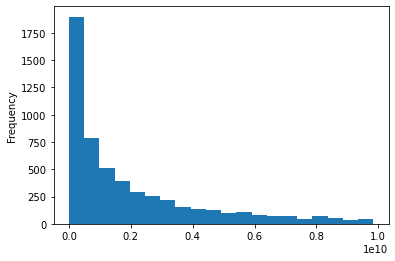

In [ ]:
# when the market cap goes high, the data becomes extremely sparse, and this data can be regarded as outliers
# delete the top 20% market cap companys and do boxplot again

financial_profile_macro_y = financial_profile_macro_y.query(""" Market_Cap <= 10000000000""")
financial_profile_macro_y.Market_Cap.plot.hist(bins=20)

In [ ]:
financial_profile_macro_y.drop(["binned_market_cap"],axis=1,inplace=True)

/var/folders/hl/w53bcsr55z7gvtqst8pfw92c0000gn/T/ipykernel_22698/3309998821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_profile_macro_y.drop(["binned_market_cap"],axis=1,inplace=True)


outlier

In [24]:
financial_profile_macro_2023_y_scaled = financial_profile_macro_2023_y.query(""" Market_Cap_2023 <= 10000000000""")

In [25]:
financial_profile_macro_2023_y_scaled.shape

(1795, 29)

# BINNED

In [26]:
bins = [0,1e8, 1e9,3e9, 5e9, 1e10]
# 使用 pd.cut 将变量分到区间中，并统计每个区间的样本数量
financial_profile_macro_2023_y_scaled['binned2020'] = pd.cut(financial_profile_macro_2023_y_scaled['Market_Cap_2020'], bins=bins,labels=range(len(bins)-1), right=False)
financial_profile_macro_2023_y_scaled['binned2021'] = pd.cut(financial_profile_macro_2023_y_scaled['Market_Cap_2021'], bins=bins,labels=range(len(bins)-1), right=False)
financial_profile_macro_2023_y_scaled['binned2022'] = pd.cut(financial_profile_macro_2023_y_scaled['Market_Cap_2022'], bins=bins,labels=range(len(bins)-1), right=False)
financial_profile_macro_2023_y_scaled['binned2023'] = pd.cut(financial_profile_macro_2023_y_scaled['Market_Cap_2023'], bins=bins, labels=range(len(bins)-1),right=False)
# 统计每个区间的样本数量
bin_counts2020 = financial_profile_macro_2023_y_scaled['binned2020'].value_counts().sort_index()
bin_counts2021 = financial_profile_macro_2023_y_scaled['binned2021'].value_counts().sort_index()
bin_counts2022 = financial_profile_macro_2023_y_scaled['binned2022'].value_counts().sort_index()
bin_counts2023 = financial_profile_macro_2023_y_scaled['binned2023'].value_counts().sort_index()
# 打印每个区间的样本数量
print(bin_counts2020)
print(bin_counts2021)
print(bin_counts2022)
print(bin_counts2023)

binned2020
0    192
1    708
2    483
3    178
4    153
Name: count, dtype: int64
binned2021
0    139
1    601
2    488
3    237
4    225
Name: count, dtype: int64
binned2022
0    263
1    680
2    470
3    190
4    164
Name: count, dtype: int64
binned2023
0    314
1    623
2    435
3    203
4    220
Name: count, dtype: int64


/var/folders/y2/y83_h7nj1sq33b1d2gqn1bhc0000gn/T/ipykernel_1173/1263693038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_profile_macro_2023_y_scaled['binned2020'] = pd.cut(financial_profile_macro_2023_y_scaled['Market_Cap_2020'], bins=bins,labels=range(len(bins)-1), right=False)
/var/folders/y2/y83_h7nj1sq33b1d2gqn1bhc0000gn/T/ipykernel_1173/1263693038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_profile_macro_2023_y_scaled['binned2021'] = pd.cut(financial_profile_macro_2023

(1795, 29)

# Model Building

### Data Preprocessing

In [27]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [28]:
financial_profile_macro_2023_y_scaled = financial_profile_macro_2023_y_scaled.reset_index()

In [ ]:
"""
columns needed to one hot:
    country
    industry
columns needed to drop:
    Ticker
"""

'\ncolumns needed to one hot:\n    country\n    industry\ncolumns needed to drop:\n    Ticker\n'

In [29]:
financial_profile_macro_2023_y_scaled.drop(["sector","exchange","quoteType"],axis=1,inplace=True)

In [30]:
financial_profile_macro_2023_y_scaled.shape

(1795, 31)

In [31]:
enc = OneHotEncoder(drop='first')
onehot_encoded = enc.fit_transform(financial_profile_macro_2023_y_scaled[["country"]])
onehot_encoded_dense = onehot_encoded.toarray()
encoded_df = pd.DataFrame(onehot_encoded_dense, columns=enc.get_feature_names_out(["country"]))
encoded_df = encoded_df.reset_index()

In [32]:
financial_profile_macro_2023_y_scaled = pd.concat([financial_profile_macro_2023_y_scaled.reset_index(drop=True), 
                                                   encoded_df.reset_index(drop=True)], axis=1)
financial_profile_macro_2023_y_scaled = financial_profile_macro_2023_y_scaled.drop(["country"],axis=1)

In [33]:
financial_profile_macro_2023_y_scaled.shape

(1795, 72)

In [43]:
financial_profile_macro_2023_y_scaled.head()

,index,Ticker,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,...,country_Singapore,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_Switzerland,country_Taiwan,country_United Arab Emirates,country_United Kingdom,country_United States
0,1,AA,2023,1.959706,4.405000e+09,944000000.0,3.030000e+09,8.310000e+09,6.320000e+08,-5.310000e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,AADI,2023,0.681302,1.245860e+08,62888000.0,2.639500e+07,2.722800e+07,1.690000e+05,-3.972000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,AAL,2023,1.297721,1.357200e+10,578000000.0,2.206200e+10,6.826000e+10,2.254000e+09,-2.596000e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,AAOI,2023,1.733689,1.726050e+08,45366000.0,9.335800e+07,1.743170e+08,2.042700e+07,-9.667000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,AAON,2023,1.204460,4.089540e+08,287000.0,1.267490e+08,2.062120e+08,4.679200e+07,-1.094910e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [44]:
financial_profile_macro_2023_y_scaled.columns

Index(['index', 'Ticker', 'Year', 'Beta', 'Current Assets',
       'Cash And Cash Equivalents', 'Current Liabilities',
       'Total Liabilities Net Minority Interest',
       'Depreciation And Amortization', 'Capital Expenditure', 'Net Income',
       'Interest Expense', 'Tax Rate For Calcs', 'industry',
       'fullTimeEmployees', 'CPI', 'PPI', 'Unemployment Rate',
       'Federal Funds Rate', 'Inflation Rate', 'Overnight Lending Rate',
       '10 Year Treasury Rate', 'Market_Cap_2020', 'Market_Cap_2021',
       'Market_Cap_2022', 'Market_Cap_2023', 'binned2020', 'binned2021',
       'binned2022', 'binned2023', 'index', 'country_Australia',
       'country_Bahamas', 'country_Belgium', 'country_Bermuda',
       'country_Brazil', 'country_British Virgin Islands', 'country_Canada',
       'country_Cayman Islands', 'country_China', 'country_Colombia',
       'country_Costa Rica', 'country_Cyprus', 'country_Denmark',
       'country_France', 'country_Germany', 'country_Greece',
       'co

In [34]:
enc = OneHotEncoder(drop='first')
onehot_encoded = enc.fit_transform(financial_profile_macro_2023_y_scaled[["industry"]])
onehot_encoded_dense = onehot_encoded.toarray()
encoded_df = pd.DataFrame(onehot_encoded_dense, columns=enc.get_feature_names_out(["industry"]))
encoded_df = encoded_df.reset_index()
financial_profile_macro_2023_y_scaled = pd.concat([financial_profile_macro_2023_y_scaled.reset_index(drop=True), 
                                                   encoded_df.reset_index(drop=True)], axis=1)
financial_profile_macro_2023_y_scaled = financial_profile_macro_2023_y_scaled.drop(["industry"],axis=1)

In [35]:
financial_profile_macro_2023_y_scaled

,index,Ticker,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,...,industry_Utilities - Diversified,industry_Utilities - Regulated Water,industry_Utilities - Renewable,industry_Utilities—Diversified,industry_Utilities—Independent Power Producers,industry_Utilities—Regulated Electric,industry_Utilities—Regulated Gas,industry_Utilities—Regulated Water,industry_Utilities—Renewable,industry_Waste Management
0,1,AA,2023,1.959706,4.405000e+09,944000000.0,3.030000e+09,8.310000e+09,6.320000e+08,-5.310000e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,AADI,2023,0.681302,1.245860e+08,62888000.0,2.639500e+07,2.722800e+07,1.690000e+05,-3.972000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,AAL,2023,1.297721,1.357200e+10,578000000.0,2.206200e+10,6.826000e+10,2.254000e+09,-2.596000e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,AAOI,2023,1.733689,1.726050e+08,45366000.0,9.335800e+07,1.743170e+08,2.042700e+07,-9.667000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,AAON,2023,1.204460,4.089540e+08,287000.0,1.267490e+08,2.062120e+08,4.679200e+07,-1.094910e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,3481,ZI,2023,1.489378,8.643000e+08,447100000.0,6.384000e+08,4.749000e+09,8.060000e+07,-2.650000e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1791,3486,ZKIN,2023,0.918462,4.324644e+07,4994411.0,2.489069e+07,3.343018e+07,9.757060e+05,-2.294462e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1792,3488,ZOM,2023,1.422562,9.988200e+07,12952000.0,9.032000e+06,1.318000e+07,6.298000e+06,-4.646000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1793,3490,ZTEK,2023,0.501722,6.248953e+06,3521420.0,1.819004e+06,2.411845e+06,6.137140e+05,-3.200990e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
financial_profile_macro_2023_y_scaled.set_index("Ticker",inplace=True)
financial_profile_macro_2023_y_scaled.drop(["index"],axis=1,inplace=True)
#financial_profile_macro_y.Year = financial_profile_macro_y.Year - 2020

In [37]:
financial_profile_macro_2023_y_scaled.head()
financial_profile_macro_2023_y_scaled.shape

(1795, 215)

In [38]:
financial_profile_macro_2023_y_scaled = financial_profile_macro_2023_y_scaled.dropna()

In [39]:
financial_profile_macro_2023_y_scaled.shape

(1671, 215)

In [40]:
financial_profile_macro_2023_y_scaled.head()

,Year,Beta,Current Assets,Cash And Cash Equivalents,Current Liabilities,Total Liabilities Net Minority Interest,Depreciation And Amortization,Capital Expenditure,Net Income,Interest Expense,...,industry_Utilities - Diversified,industry_Utilities - Regulated Water,industry_Utilities - Renewable,industry_Utilities—Diversified,industry_Utilities—Independent Power Producers,industry_Utilities—Regulated Electric,industry_Utilities—Regulated Gas,industry_Utilities—Regulated Water,industry_Utilities—Renewable,industry_Waste Management
Ticker,,,,,,,,,,,,,,,,,,,,,
AADI,2023,0.681302,124586000.0,62888000.0,26395000.0,2.722800e+07,169000.0,-3972000.0,-65765000.0,231000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAOI,2023,1.733689,172605000.0,45366000.0,93358000.0,1.743170e+08,20427000.0,-9667000.0,-56048000.0,9428000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAON,2023,1.204460,408954000.0,287000.0,126749000.0,2.062120e+08,46792000.0,-109491000.0,177623000.0,4843000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAT,2023,1.177974,190179000.0,82888000.0,98119000.0,1.831006e+09,119500000.0,-82980000.0,64690000.0,64706000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABAT,2023,0.163360,18406048.0,7001786.0,15798298.0,1.620749e+07,1779781.0,-12689341.0,-52501824.0,158078.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
print(financial_profile_macro_2023_y_scaled['binned2023'].dtype)

category


In [42]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
financial_profile_macro_2023_y_scaled['binned_2023'] = label_encoder.fit_transform(financial_profile_macro_2023_y_scaled['binned2023'])
financial_profile_macro_2023_y_scaled['binned_2022'] = label_encoder.fit_transform(financial_profile_macro_2023_y_scaled['binned2022'])
financial_profile_macro_2023_y_scaled['binned_2021'] = label_encoder.fit_transform(financial_profile_macro_2023_y_scaled['binned2021'])
financial_profile_macro_2023_y_scaled['binned_2020'] = label_encoder.fit_transform(financial_profile_macro_2023_y_scaled['binned2020'])

/var/folders/y2/y83_h7nj1sq33b1d2gqn1bhc0000gn/T/ipykernel_1173/3351795740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_profile_macro_2023_y_scaled['binned_2023'] = label_encoder.fit_transform(financial_profile_macro_2023_y_scaled['binned2023'])
/var/folders/y2/y83_h7nj1sq33b1d2gqn1bhc0000gn/T/ipykernel_1173/3351795740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_profile_macro_2023_y_scaled['binned_2022'] = label_encoder.fit_transform(financial_profile_macro_2023_y_scaled['

In [56]:
print(financial_profile_macro_2023_y_scaled['binned_2023'].dtype)

int64


### Standardize and PCA

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [63]:
df_with_standardize = financial_profile_macro_2023_y_scaled.copy()
# df_with_standardize = df_with_standardize.query("""Year == 3""")
standscaler = StandardScaler()
stand_list = ['Beta', 'Current Assets', 'Cash And Cash Equivalents',
       'Current Liabilities', 'Total Liabilities Net Minority Interest',
       'Depreciation And Amortization', 'Capital Expenditure', 'Net Income',
       'Interest Expense', 'Tax Rate For Calcs', 'fullTimeEmployees']
data_stand = standscaler.fit_transform(df_with_standardize[stand_list])
data_stand_df = pd.DataFrame(data_stand)
data_stand_df.columns = stand_list

In [64]:
for i in stand_list:
    df_with_standardize[i] = data_stand_df[i].to_list()

In [57]:
df_with_standardize.shape

(1671, 219)

In [58]:
df_with_standardize.isna().sum()

Year                         0
Beta                         0
Current Assets               0
Cash And Cash Equivalents    0
Current Liabilities          0
                            ..
industry_Waste Management    0
binned_2023                  0
binned_2022                  0
binned_2021                  0
binned_2020                  0
Length: 219, dtype: int64

In [71]:
pca = PCA(n_components=15)
X_variable_after_pca = pca.fit_transform(df_with_standardize[['Beta',
 'Current Assets',
 'Cash And Cash Equivalents',
 'Current Liabilities',
 'Total Liabilities Net Minority Interest',
 'Depreciation And Amortization',
 'Capital Expenditure',
 'Net Income',
 'Interest Expense',
 'Tax Rate For Calcs',
 'fullTimeEmployees',
 'CPI',
 'PPI',
 'Unemployment Rate',
 'Federal Funds Rate',
 'Inflation Rate',
 'Overnight Lending Rate',
 '10 Year Treasury Rate',
 'binned2020','binned2021','binned2022',
 'country_Australia',
 'country_Bahamas',
 'country_Belgium',
 'country_Bermuda',
 'country_Brazil',
 'country_British Virgin Islands',
 'country_Canada',
 'country_Cayman Islands',
 'country_China',
 'country_Colombia',
 'country_Costa Rica',
 'country_Cyprus',
 'country_Denmark',
 'country_France',
 'country_Germany',
 'country_Greece',
 'country_Hong Kong',
 'country_India',
 'country_Ireland',
 'country_Israel',
 'country_Italy',
 'country_Jersey',
 'country_Kazakhstan',
 'country_Luxembourg',
 'country_Malaysia',
 'country_Mexico',
 'country_Monaco',
 'country_Netherlands',
 'country_Norway',
 'country_Panama',
 'country_Philippines',
 'country_Singapore',
 'country_South Africa',
 'country_South Korea',
 'country_Spain',
 'country_Sweden',
 'country_Switzerland',
 'country_Taiwan',
 'country_United Arab Emirates',
 'country_United Kingdom',
 'country_United States',
 'industry_Aerospace & Defense',
 'industry_Agricultural Inputs',
 'industry_Airlines',
 'industry_Airports & Air Services',
 'industry_Aluminum',
 'industry_Apparel Manufacturing',
 'industry_Apparel Retail',
 'industry_Asset Management',
 'industry_Auto & Truck Dealerships',
 'industry_Auto Manufacturers',
 'industry_Auto Parts',
 'industry_Beverages—Non-Alcoholic',
 'industry_Beverages—Wineries & Distilleries',
 'industry_Biotechnology',
 'industry_Broadcasting',
 'industry_Building Materials',
 'industry_Building Products & Equipment',
 'industry_Business Equipment & Supplies',
 'industry_Capital Markets',
 'industry_Chemicals',
 'industry_Coking Coal',
 'industry_Communication Equipment',
 'industry_Computer Hardware',
 'industry_Confectioners',
 'industry_Conglomerates',
 'industry_Consulting Services',
 'industry_Consumer Electronics',
 'industry_Copper',
 'industry_Credit Services',
 'industry_Department Stores',
 'industry_Diagnostics & Research',
 'industry_Discount Stores',
 'industry_Drug Manufacturers - General',
 'industry_Drug Manufacturers - Specialty & Generic',
 'industry_Drug Manufacturers—General',
 'industry_Drug Manufacturers—Specialty & Generic',
 'industry_Education & Training Services',
 'industry_Electrical Equipment & Parts',
 'industry_Electronic Components',
 'industry_Electronic Gaming & Multimedia',
 'industry_Electronics & Computer Distribution',
 'industry_Engineering & Construction',
 'industry_Entertainment',
 'industry_Farm & Heavy Construction Machinery',
 'industry_Farm Products',
 'industry_Financial Conglomerates',
 'industry_Financial Data & Stock Exchanges',
 'industry_Food Distribution',
 'industry_Footwear & Accessories',
 'industry_Furnishings, Fixtures & Appliances',
 'industry_Gambling',
 'industry_Gold',
 'industry_Grocery Stores',
 'industry_Health Information Services',
 'industry_Healthcare Plans',
 'industry_Home Improvement Retail',
 'industry_Household & Personal Products',
 'industry_Industrial Distribution',
 'industry_Information Technology Services',
 'industry_Infrastructure Operations',
 'industry_Insurance - Life',
 'industry_Insurance Brokers',
 'industry_Insurance—Specialty',
 'industry_Integrated Freight & Logistics',
 'industry_Internet Content & Information',
 'industry_Internet Retail',
 'industry_Leisure',
 'industry_Lodging',
 'industry_Lumber & Wood Production',
 'industry_Luxury Goods',
 'industry_Marine Shipping',
 'industry_Medical Care Facilities',
 'industry_Medical Devices',
 'industry_Medical Distribution',
 'industry_Medical Instruments & Supplies',
 'industry_Metal Fabrication',
 'industry_Mortgage Finance',
 'industry_Oil & Gas Drilling',
 'industry_Oil & Gas E&P',
 'industry_Oil & Gas Equipment & Services',
 'industry_Oil & Gas Integrated',
 'industry_Oil & Gas Midstream',
 'industry_Oil & Gas Refining & Marketing',
 'industry_Other Industrial Metals & Mining',
 'industry_Other Precious Metals & Mining',
 'industry_Packaged Foods',
 'industry_Packaging & Containers',
 'industry_Paper & Paper Products',
 'industry_Personal Services',
 'industry_Pharmaceutical Retailers',
 'industry_Pollution & Treatment Controls',
 'industry_Publishing',
 'industry_REIT - Diversified',
 'industry_REIT - Hotel & Motel',
 'industry_REIT - Office',
 'industry_REIT - Residential',
 'industry_REIT - Retail',
 'industry_REIT—Diversified',
 'industry_REIT—Healthcare Facilities',
 'industry_REIT—Hotel & Motel',
 'industry_REIT—Industrial',
 'industry_REIT—Office',
 'industry_REIT—Residential',
 'industry_REIT—Retail',
 'industry_REIT—Specialty',
 'industry_Railroads',
 'industry_Real Estate Services',
 'industry_Real Estate—Development',
 'industry_Real Estate—Diversified',
 'industry_Recreational Vehicles',
 'industry_Rental & Leasing Services',
 'industry_Residential Construction',
 'industry_Resorts & Casinos',
 'industry_Restaurants',
 'industry_Scientific & Technical Instruments',
 'industry_Security & Protection Services',
 'industry_Semiconductor Equipment & Materials',
 'industry_Semiconductors',
 'industry_Shell Companies',
 'industry_Software - Application',
 'industry_Software - Infrastructure',
 'industry_Software—Application',
 'industry_Software—Infrastructure',
 'industry_Solar',
 'industry_Specialty Business Services',
 'industry_Specialty Chemicals',
 'industry_Specialty Industrial Machinery',
 'industry_Specialty Retail',
 'industry_Staffing & Employment Services',
 'industry_Steel',
 'industry_Telecom Services',
 'industry_Textile Manufacturing',
 'industry_Tobacco',
 'industry_Tools & Accessories',
 'industry_Travel Services',
 'industry_Trucking',
 'industry_Uranium',
 'industry_Utilities - Diversified',
 'industry_Utilities - Regulated Water',
 'industry_Utilities - Renewable',
 'industry_Utilities—Diversified',
 'industry_Utilities—Independent Power Producers',
 'industry_Utilities—Regulated Electric',
 'industry_Utilities—Regulated Gas',
 'industry_Utilities—Regulated Water',
 'industry_Utilities—Renewable',
 'industry_Waste Management']])
X_variable_after_pca_df = pd.DataFrame(X_variable_after_pca)
print(X_variable_after_pca_df.shape)
X_variable_after_pca_df = X_variable_after_pca_df.dropna()

(1671, 15)


### Split train test dataset

In [54]:
from sklearn.model_selection import train_test_split

#### Version1-Raw Data

In [75]:
X = financial_profile_macro_y.drop("Market_Cap",axis=1)
Y = financial_profile_macro_y["Market_Cap"]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

#### Version2-Single Year Data

In [ ]:
financial_profile_macro_y_2023 = financial_profile_macro_y.query("""Year == 3""")

In [ ]:
X = financial_profile_macro_y_2023.drop("Market_Cap",axis=1)
Y = financial_profile_macro_y_2023["Market_Cap"]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

#### Version3-PCA

In [72]:
X = X_variable_after_pca_df
Y = financial_profile_macro_2023_y_scaled["binned2023"]
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X, Y, test_size=0.3, random_state=42)

#### Version4-T-3 model

In [55]:
X = financial_profile_macro_2023_y_scaled.drop(["Market_Cap_2023","Market_Cap_2022","Market_Cap_2021","Market_Cap_2020","binned2023","binned_2023","binned_2022","binned_2021","binned_2020"],axis=1)
Y = financial_profile_macro_2023_y_scaled["binned2023"]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

Version5-KNN model

In [184]:
Xknn = financial_profile_macro_2023_y_scaled.drop(["Market_Cap_2023","Market_Cap_2022","Market_Cap_2021","Market_Cap_2020","binned2023","binned_2023","binned_2022","binned_2021","binned_2020"],axis=1).values
Yknn = financial_profile_macro_2023_y_scaled["binned2023"]
X_trainknn, X_testknn, y_trainknn, y_testknn = train_test_split(
    Xknn, Yknn, test_size=0.3, random_state=42)

In [64]:
print(X_train.dtypes)

Year                                       int64
Beta                                     float64
Current Assets                           float64
Cash And Cash Equivalents                float64
Current Liabilities                      float64
                                          ...   
industry_Utilities—Regulated Electric    float64
industry_Utilities—Regulated Gas         float64
industry_Utilities—Regulated Water       float64
industry_Utilities—Renewable             float64
industry_Waste Management                float64
Length: 210, dtype: object


## Model Attamption

### random forest regression

In [63]:
from sklearn.ensemble import RandomForestClassifier
rfclassifier = RandomForestClassifier(class_weight='balanced',max_depth=2, random_state=0)
rfclassifier.fit(X_train, y_train)
y_predict = rfclassifier.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.5219123505976095


### neural network

In [66]:
from sklearn.neural_network import MLPClassifier

In [170]:
nnregressor = MLPClassifier(alpha=0.0001,random_state=1, max_iter=2000,hidden_layer_sizes=(100,100))
nnregressor.fit(X_train_pca,y_train_pca)
pred_y = nnregressor.predict(X_test_pca)
accuracy = accuracy_score(y_test_pca, pred_y)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5976


Gridient boost

In [171]:
from sklearn.ensemble import GradientBoostingClassifier
classifier=GradientBoostingClassifier(n_estimators=1,learning_rate=0.4,random_state=0) 
classifier.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report 
y_pred = classifier.predict(X_test) 
cm = confusion_matrix(y_test, y_pred) 
print(cm) 
print(accuracy_score(y_test, y_pred)) 
print(classification_report(y_pred, y_test))

[[ 67  31   0   0   0]
 [  8 139  21   0   0]
 [  0  16 115   5   1]
 [  0   0  22  24   7]
 [  0   0   1  19  26]]
0.7390438247011952
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        75
           1       0.83      0.75      0.79       186
           2       0.84      0.72      0.78       159
           3       0.45      0.50      0.48        48
           4       0.57      0.76      0.65        34

    accuracy                           0.74       502
   macro avg       0.67      0.73      0.69       502
weighted avg       0.76      0.74      0.74       502



XGBOOST

In [79]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
xgb = XGBClassifier(random_state=42,enable_categorical=True)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

print(f"Best parameters for XGB: {grid_search_xgb.best_params_}")
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
accuracy_xgb = best_xgb_model.score(X_test, y_test)
print(f"XGB Test Accuracy: {accuracy_xgb:.4f}")
cm = confusion_matrix(y_test, y_pred_xgb) 
print(cm) 
print(classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END 

KNN classifier

In [180]:
!pip install --upgrade numpy
import numpy as np


In [185]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_trainknn, y_trainknn)
y_predknn = knn.predict(X_testknn)
accuracy = accuracy_score(y_testknn, y_predknn)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_testknn, y_predknn))


Accuracy: 0.5080
              precision    recall  f1-score   support

           0       0.63      0.69      0.66        98
           1       0.53      0.64      0.58       168
           2       0.47      0.42      0.44       137
           3       0.33      0.13      0.19        53
           4       0.33      0.33      0.33        46

    accuracy                           0.51       502
   macro avg       0.46      0.44      0.44       502
weighted avg       0.49      0.51      0.49       502



## Model Parameter Selection

In [51]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### random forest regression

In [173]:
RF_model = RandomForestClassifier(class_weight='balanced',random_state=0)

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'bootstrap': [True, False]  
}

grid_search = GridSearchCV(estimator=RF_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
accuracy = best_rf.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

### neural network

In [161]:
mlp_model = MLPClassifier(random_state=42)


param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100,50)], 
    'activation': ['relu', 'tanh'], 
    'solver': ['adam', 'sgd'],   
    'max_iter': [500, 1000],
    'alpha' :[0.01,0.001,0.0001]
}

grid_search = GridSearchCV(estimator=mlp_model, 
                           param_grid=param_grid,
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1) 

grid_search.fit(X_train_pca, y_train_pca)


print(f'Best parameters: {grid_search.best_params_}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
accuracy = best_model.score(X_test_pca, y_test_pca)
print(f"Test Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_base.py:65: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_base.py:65: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_base.py:65: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1

Best parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'max_iter': 500, 'solver': 'adam'}
Test Accuracy: 0.6653


Gridient boosting

In [135]:
param_grid = {'n_estimators': [1, 10, 100,1000],'learning_rate': [0.2, 0.4, 0.6, 0.8]} 
grid=GridSearchCV(GradientBoostingClassifier(random_state=0),param_grid, scoring ='accuracy') 
grid.fit(X_train,y_train) 
grid.best_estimator_, grid.best_params_

(GradientBoostingClassifier(learning_rate=0.2, n_estimators=10, random_state=0),
 {'learning_rate': 0.2, 'n_estimators': 10})

In [174]:
classifier=GradientBoostingClassifier(n_estimators=10,learning_rate=0.2,random_state=0) 
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test) 
cm = confusion_matrix(y_test, y_pred) 
print(cm) 
print(accuracy_score(y_test, y_pred)) 
print(classification_report(y_pred, y_test))

[[ 82  16   0   0   0]
 [ 14 136  18   0   0]
 [  0  17 110   8   2]
 [  0   0  19  23  11]
 [  0   0   1  11  34]]
0.7669322709163346
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        96
           1       0.81      0.80      0.81       169
           2       0.80      0.74      0.77       148
           3       0.43      0.55      0.48        42
           4       0.74      0.72      0.73        47

    accuracy                           0.77       502
   macro avg       0.72      0.73      0.73       502
weighted avg       0.77      0.77      0.77       502



KNN classifier

In [186]:

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_trainknn, y_trainknn)
print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [188]:
knn = KNeighborsClassifier(n_neighbors=9,metric="manhattan",weights= "distance")
knn.fit(X_trainknn, y_trainknn)
y_predknn = knn.predict(X_testknn)
accuracy = accuracy_score(y_testknn, y_predknn)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_testknn, y_predknn))

Accuracy: 0.5478
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        98
           1       0.58      0.65      0.62       168
           2       0.53      0.49      0.51       137
           3       0.18      0.08      0.11        53
           4       0.38      0.54      0.45        46

    accuracy                           0.55       502
   macro avg       0.47      0.49      0.48       502
weighted avg       0.53      0.55      0.53       502



SVM classifier

In [75]:
from sklearn.svm import SVC
svm = SVC()

param_grid = {
    'C': [0.1, 1,10],                # 正则化参数
    'gamma': ['scale',0.1, 1],
    'kernel': ['rbf', 'poly','linear','sigmoid']        # 核函数类型
}
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5,n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_pca, y_test_pca)
print("Test accuracy:", test_score)

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.7493598914199773
Test accuracy: 0.749003984063745


In [76]:
from sklearn.svm import SVC
classifier = SVC(kernel="linear",C=1, random_state=0) 
classifier.fit(X_train_pca, y_train_pca)
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_pca) 
cm = confusion_matrix(y_test_pca, y_pred) 
accuracy = accuracy_score(y_test_pca, y_pred) 
print(cm, accuracy)

[[ 79  19   0   0   0]
 [ 12 136  20   0   0]
 [  0  19 111   6   1]
 [  0   0  22  24   7]
 [  0   0   1  19  26]] 0.749003984063745


### Best Financial Model -- XG BOOST

In [85]:
xgb = XGBClassifier(random_state=42,colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample= 0.8,enable_categorical=True)
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.7788844621513944


# Store Model

In [80]:
X_train.columns.to_list()

['Year',
 'Beta',
 'Current Assets',
 'Cash And Cash Equivalents',
 'Current Liabilities',
 'Total Liabilities Net Minority Interest',
 'Depreciation And Amortization',
 'Capital Expenditure',
 'Net Income',
 'Interest Expense',
 'Tax Rate For Calcs',
 'fullTimeEmployees',
 'CPI',
 'PPI',
 'Unemployment Rate',
 'Federal Funds Rate',
 'Inflation Rate',
 'Overnight Lending Rate',
 '10 Year Treasury Rate',
 'binned2020',
 'binned2021',
 'binned2022',
 'country_Australia',
 'country_Bahamas',
 'country_Belgium',
 'country_Bermuda',
 'country_Brazil',
 'country_British Virgin Islands',
 'country_Canada',
 'country_Cayman Islands',
 'country_China',
 'country_Colombia',
 'country_Costa Rica',
 'country_Cyprus',
 'country_Denmark',
 'country_France',
 'country_Germany',
 'country_Greece',
 'country_Hong Kong',
 'country_India',
 'country_Ireland',
 'country_Israel',
 'country_Italy',
 'country_Jersey',
 'country_Kazakhstan',
 'country_Luxembourg',
 'country_Malaysia',
 'country_Mexico',
 'cou

In [81]:
with open("X_variable_list.txt","w") as f:
    f.write(str(X_train.columns.to_list()))

In [82]:
! pip install joblib

In [83]:
import joblib

In [86]:
joblib.dump(xgb, 'XGboost model.joblib')

['XGboost model.joblib']